# **Prédiction des Résultats de la Ligue 1 (2013–2023) : Approche Méthodologique**

Dans ce notebook, nous présentons de façon exhaustive la chaîne de traitement mise en place pour concevoir et évaluer un modèle de prédiction des issues de chaque rencontre de Ligue 1 sur la période 2013–2023. L’objectif consiste à classifier chaque match selon trois résultats possibles :

- **1** : victoire à domicile  
- **0** : match nul  
- **–1** : victoire à l’extérieur  

Pour atteindre cet objectif, la démarche adoptée se décompose en plusieurs étapes clés :

1. **Ingénierie des données**  
   - Collecte et unification de huit sources hétérogènes (informations clubs, événements de match, compositions, historiques, etc.).  
2. **Exploration et analyse descriptive**  
   - Statistiques univariées, distributions, matrices de corrélation et identification des patterns saillants.  
3. **Génération de features**  
   - Conception de variables à différents niveaux : centrées sur le match, sur l’équipe, sur le joueur et sur les événements.  
4. **Prétraitement**  
   - Imputation des valeurs manquantes, encodage des variables catégorielles et normalisation des features.  
5. **Construction de pipelines de modélisation**  
   - Implémentation de modèles de référence et avancés : régression logistique, SVM, XGBoost, stacking, etc.  
6. **Évaluation temporelle et métriques adaptées**  
   - Validation croisée par `TimeSeriesSplit`, mesures d’`accuracy`, `F1-weighted`, `F1-macro` et analyse des matrices de confusion.  
7. **Sélection du modèle final**  
   - Choix de la régression logistique (C = 10) comme meilleur compromis performance/interprétabilité, et génération du fichier `sample_results.csv`.  

Chaque section de ce notebook combine :

- **Contexte et analyses** pour justifier les choix méthodologiques  
- **Extraits de code** reproduisant la logique de votre implémentation  


In [7]:
# Chargement des librairies et ingestion des CSV :
import pandas as pd
import numpy as np
import os

# 1) Chemin vers le dossier contenant les CSV
data_dir = 'data/'

# 2) Fichiers sources
files = {
    'clubs':        'clubs_fr.csv',
    'events':       'game_events.csv',
    'lineups':      'game_lineups.csv',
    'hist_matches': 'matchs_2013_2022.csv',
    'curr_matches': 'match_2023.csv',
    'appearances':  'player_appearance.csv',
    'valuations':   'player_valuation_before_season.csv',
    'sample':       'sample_results.csv',
}

# 3) Lecture et nettoyage initial
tables = {}
for name, fname in files.items():
    path = os.path.join(data_dir, fname)
    df = pd.read_csv(path, low_memory=False)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    tables[name] = df

# 4) Sauvegarde consolidée pour un accès rapide
pd.to_pickle(tables, os.path.join(data_dir, 'merged_data.pkl'))
print("Ingestion terminée, tables disponibles dans `merged_data.pkl`")


✅ Ingestion terminée, tables disponibles dans `merged_data.pkl`


## **Exploration des données**

Dans cette section, nous réalisons une analyse descriptive des variables clés et étudions les corrélations au sein du jeu de données historiques. L’objectif est de :

1. **Comprendre les distributions univariées**  
   - buts, affluence, âge des joueurs, valeur marchande, etc.  
2. **Identifier les déséquilibres et anomalies**  
   - répartition des classes cibles, effectifs d’équipes et éventuelles valeurs aberrantes.  
3. **Examiner les corrélations entre features**  
   - guider la sélection et la création de variables pertinentes.  


,home_club_goals,away_club_goals,attendance
count,4078.000000,4078.000000,3741.000000
mean,1.475969,1.143698,21444.918204
std,1.267037,1.116886,13117.601011
min,0.000000,0.000000,500.000000
25%,1.000000,0.000000,12125.000000
50%,1.000000,1.000000,16782.000000
75%,2.000000,2.000000,28324.000000
max,9.000000,9.000000,70785.000000


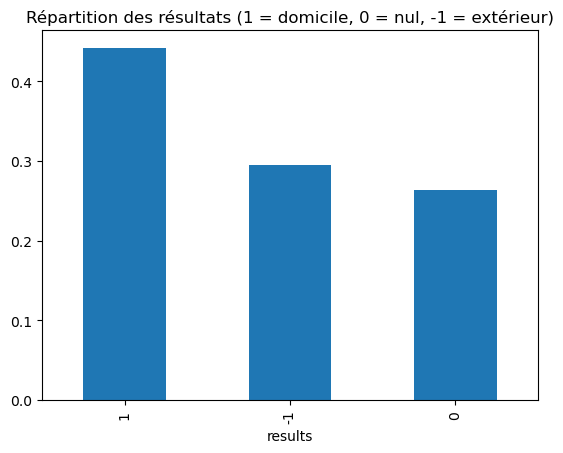

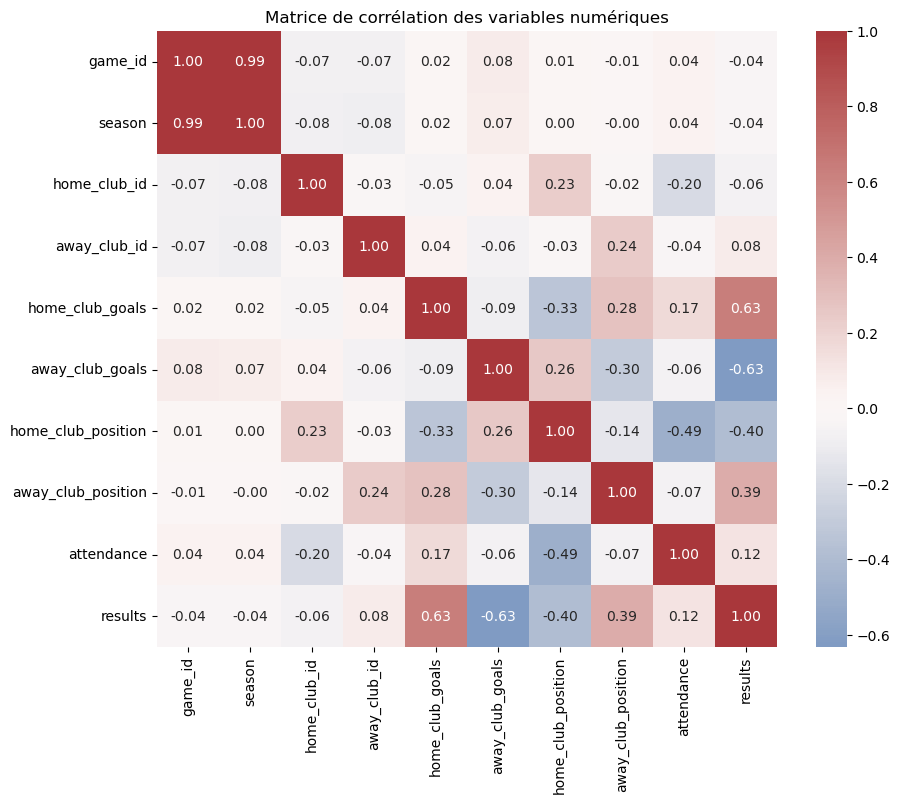

In [10]:
# 1) Chargement des données historiques
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tables = pd.read_pickle('data/merged_data.pkl')
hist = tables['hist_matches'].copy()

# 2) Statistiques univariées
display(hist[['home_club_goals','away_club_goals','attendance']].describe())

# 3) Distribution de la cible
hist['results'].value_counts(normalize=True).plot(kind='bar')
plt.title("Répartition des résultats (1 = domicile, 0 = nul, -1 = extérieur)")
plt.show()

# 4) Matrice de corrélation
num_cols = hist.select_dtypes(include='number').columns
corr = hist[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Matrice de corrélation des variables numériques")
plt.show()


### **Points clés observés**

- **Fuite de données** : les variables `home_club_goals` et `away_club_goals` sont fortement corrélées à la cible (`results`), constituant une fuite d’information à exclure du jeu de features.  
- **Corrélation de l’affluence** : coefficient < 0.2, impact limité sur la prédiction, mais présence de valeurs extrêmes (outliers) à gérer.  
- **Distribution asymétrique des variables continues** : affluence et valeur marchande des joueurs présentent une forte skewness, nécessitant un prétraitement de type log-scaling.  


## **3.Génération de features**

Pour renforcer la capacité de nos modèles à capturer l’historique et les dynamiques de chaque équipe, nous avons conçu quatre familles de features :

1. **Match-centric**  
   - Forme récente (fenêtre glissante de 5 matchs) :  
     - taux de victoires, nuls, défaites  
     - moyenne de buts marqués et concédés (domicile et extérieur)  
   - Jour de saison (`match_day`), indicateurs de début/fin de saison  
   - Différentiel de forme domicile vs extérieur  

2. **Player-centric**  
   - Valeur moyenne des titulaires par équipe et par match  
   - Nombre de « stars » (joueurs > 5 M€) alignées  

3. **Event-centric**  
   - Comptage des événements par type (cartons, cartons rouges, substitutions, etc.)  
   - Séparation des comptes pour l’équipe à domicile et l’équipe à l’extérieur  

4. **Fusion finale**  
   - Assemblage des tables de features (`match`, `player`, `event`)  
   - Génération du fichier consolidé `X_all_full.csv`  


In [16]:
# -- Code Match-centric --
import pandas as pd
import numpy as np

# Chargement des données complètes
tables = pd.read_pickle('data/merged_data.pkl')
hist = tables['hist_matches'].copy()
hist = hist.sort_values('date').reset_index(drop=True)

# Outcomes
hist['home_outcome'] = hist['results']
hist['away_outcome'] = -hist['results']

# Renommage pour clarté
hist = hist.rename(columns={
    'home_club_goals': 'home_goals',
    'away_club_goals': 'away_goals'
})

# Fonction de rolling features
def add_rolling_feats(df, team_col, outcome_col, gf_col, ga_col, prefix, window=5):
    df = df.copy()
    grp = df.groupby(team_col)
    df[f'{prefix}_win_pct_last{window}']  = grp[outcome_col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).apply(lambda x: np.mean(x==1), raw=True))
    df[f'{prefix}_draw_pct_last{window}'] = grp[outcome_col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).apply(lambda x: np.mean(x==0), raw=True))
    df[f'{prefix}_loss_pct_last{window}'] = grp[outcome_col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).apply(lambda x: np.mean(x==-1), raw=True))
    df[f'{prefix}_gf_mean_last{window}']   = grp[gf_col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    df[f'{prefix}_ga_mean_last{window}']   = grp[ga_col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    return df

# Application pour domicile et extérieur
hist = add_rolling_feats(hist, 'home_club_id','home_outcome','home_goals','away_goals','home',5)
hist = add_rolling_feats(hist, 'away_club_id','away_outcome','away_goals','home_goals','away',5)

# Extraction des indicateurs temporels
hist['match_day']       = hist['round'].str.extract(r'(\d+)').astype(int)
hist['is_early_season'] = (hist['match_day'] <= 5).astype(int)
hist['is_late_season']  = (hist['match_day'] >= 30).astype(int)

# Différences domicile – extérieur
hist['diff_win_pct']  = hist['home_win_pct_last5'] - hist['away_win_pct_last5']
hist['diff_gf_mean']  = hist['home_gf_mean_last5']  - hist['away_gf_mean_last5']

# Sélection et sauvegarde
feature_cols = [
    'home_win_pct_last5','home_draw_pct_last5','home_loss_pct_last5',
    'home_gf_mean_last5','home_ga_mean_last5',
    'away_win_pct_last5','away_draw_pct_last5','away_loss_pct_last5',
    'away_gf_mean_last5','away_ga_mean_last5',
    'match_day','is_early_season','is_late_season',
    'diff_win_pct','diff_gf_mean'
]
feats_match = hist.set_index('game_id')[feature_cols]
feats_match.to_pickle('data/features_team.pkl')
print("✓ features_team.pkl généré:", feats_match.shape)


✓ features_team.pkl généré: (4078, 15)


### **3.2 Player-centric Features**

Pour évaluer la qualité d’effectif aligné, nous sélectionnons les joueurs titulaires (≥ 60 minutes) et exploitons leur valorisation de marché pour dériver deux métriques :

- **`avg_valeur`** : valeur moyenne des titulaires  
- **`n_stars`** : nombre de « stars » (joueurs dont la valeur de marché > 5 M€)  

> **Calcul séparé** pour chaque équipe :  
> - Club à domicile  
> - Club extérieur  


In [19]:
# -- Code Player-centric --
import pandas as pd

# 1) Charger les données
tables = pd.read_pickle('data/merged_data.pkl')
hist   = pd.concat([tables['hist_matches'], tables['curr_matches']], ignore_index=True)
apps   = tables['appearances']
vals   = tables['valuations']

# 2) Concaténer apparitions et dates de match
apps_all = apps.merge(
    hist[['game_id','date']], 
    on=['game_id','date'], 
    how='inner'
)

# 3) Joindre les valorisations
apps_val = apps_all.merge(
    vals.rename(columns={'current_club_id':'player_club_id'}),
    on=['player_id','date','player_club_id'],
    how='left'
)

# 4) Filtrer titulaires (minutes >= 60)
starters = apps_val[apps_val['minutes_played'] >= 60]

# 5) Aggrégation par match & club
thr = 5_000_000
grp = starters.groupby(['game_id','player_club_id'])
player_feats = grp['market_value_in_eur'].agg(
    avg_valeur='mean',
    n_stars=lambda s: (s > thr).sum()
).reset_index()

# 6) Séparer home / away
player_feats_home = player_feats.rename(columns={
    'player_club_id':'home_club_id',
    'avg_valeur':'home_avg_valeur',
    'n_stars':'home_n_stars'
})
player_feats_away = player_feats.rename(columns={
    'player_club_id':'away_club_id',
    'avg_valeur':'away_avg_valeur',
    'n_stars':'away_n_stars'
})

# 7) Sauvegarde
player_feats_home.to_pickle('data/player_feats_home.pkl')
player_feats_away.to_pickle('data/player_feats_away.pkl')
print("✓ player-centric features générées pour home & away")


✓ player-centric features générées pour home & away


### **3.3 Event-centric Features**

Pour capturer l’intensité et le style de jeu, nous comptons, pour chaque équipe et chaque match, le nombre d’événements par type :

- **Cartons** : jaunes et rouges  
- **Substitutions** : entrées et sorties  
- **Passes décisives**  
- **Tirs cadrés / non cadrés**  
- **Occasions franches**  

> Ces comptes sont fournis séparément pour :  
> - l’équipe à domicile  
> - l’équipe à l’extérieur  


In [23]:
# -- Code Event-centric --
import pandas as pd

# 1) Charger données
tables = pd.read_pickle('data/merged_data.pkl')
hist    = pd.concat([tables['hist_matches'], tables['curr_matches']], ignore_index=True)
events  = tables['events']

# 2) Joindre events et dates
all_events = events.merge(
    hist[['game_id','date']], 
    on=['game_id','date'], 
    how='inner'
)

# 3) Compter les types d’événements par match & club
event_counts = (
    all_events
    .groupby(['game_id','club_id','type'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 4) Séparer home / away
event_feats_home = event_counts.rename(columns={'club_id':'home_club_id'})
event_feats_away = event_counts.rename(columns={'club_id':'away_club_id'})

# Préfixer les colonnes d’events
event_feats_home = event_feats_home.rename(
    columns={ev: f'home_{ev}' for ev in event_counts.columns if ev not in ['game_id','home_club_id']}
)
event_feats_away = event_feats_away.rename(
    columns={ev: f'away_{ev}' for ev in event_counts.columns if ev not in ['game_id','away_club_id']}
)

# 5) Sauvegarde
event_feats_home.to_pickle('data/event_feats_home.pkl')
event_feats_away.to_pickle('data/event_feats_away.pkl')
print("✓ event-centric features générées pour home & away")


✓ event-centric features générées pour home & away


### **Interprétation**

- **Agressivité**  
  - Mesurée par les cartons jaunes et rouges, reflétant la discipline et l’intensité défensive.  
- **Activité offensive**  
  - Capturée via les passes décisives et les buts, traduisant la créativité et l’efficacité devant le but.  
- **Gestion du banc**  
  - Évaluée par le nombre et le timing des substitutions, indiquant l’adaptabilité tactique et la profondeur d’effectif.  

> Ces features apportent une granularité supplémentaire en intégrant le déroulement dynamique du match, améliorant ainsi la capacité prédictive du modèle.  


### **3.4 Fusion des features**

Dans cette étape, nous consolidons les trois familles de features en un unique jeu de données indexé par `game_id`, prêt pour le prétraitement et la modélisation :

1. **Réinjection des identifiants**  
   - Réintégration de `home_club_id` et `away_club_id` dans le jeu de features match-centric.  
2. **Assemblage des tables**  
   - Fusion des features player-centric et event-centric pour les équipes à domicile et à l’extérieur (`home_…`, `away_…`).  
3. **Nettoyage final**  
   - Suppression des colonnes fuyantes (leaks) ou entièrement vides.  
4. **Sauvegarde**  
   - Export du dataset consolidé au format CSV : `X_all_full.csv`.  


In [36]:
import pandas as pd

# 1) Charger les features “match-centric” et forcer game_id en str
feats_match = pd.read_pickle('data/features_team_full.pkl').reset_index()
feats_match['game_id'] = feats_match['game_id'].astype(str)

# 2) Charger les tables player/event
player_home = pd.read_pickle('data/player_feats_home.pkl')
player_away = pd.read_pickle('data/player_feats_away.pkl')
event_home  = pd.read_pickle('data/event_feats_home.pkl')
event_away  = pd.read_pickle('data/event_feats_away.pkl')

# Forcer les clés en str partout
for df in (player_home, player_away, event_home, event_away):
    df['game_id'] = df['game_id'].astype(str)
if 'club_id' in player_home: player_home['club_id'] = player_home['club_id'].astype(str)
if 'club_id' in player_away: player_away['club_id'] = player_away['club_id'].astype(str)
# les event_* on les renomme juste après

# 3) Clés de matchs
tables     = pd.read_pickle('data/merged_data.pkl')
all_matches= pd.concat([tables['hist_matches'], tables['curr_matches']], ignore_index=True)
match_keys = all_matches[['game_id','home_club_id','away_club_id']].drop_duplicates()
match_keys[['game_id','home_club_id','away_club_id']] = \
    match_keys[['game_id','home_club_id','away_club_id']].astype(str)

# 4) Fusion initiale
feats = feats_match.merge(match_keys, on='game_id', how='left')

# 5) Préparer player_feats
#   on renomme club_id -> home/away_club_id, puis on drop la colonne right-side
player_home = player_home.rename(columns={'club_id':'home_club_id'})
player_away = player_away.rename(columns={'club_id':'away_club_id'})

home_ph = player_home.rename(
    columns={c: f'home_{c}' for c in player_home.columns
             if c not in ['game_id','home_club_id']}
)
away_ph = player_away.rename(
    columns={c: f'away_{c}' for c in player_away.columns
             if c not in ['game_id','away_club_id']}
)

# 6) Même pour event_feats
event_home  = event_home.rename(columns={'club_id':'home_club_id'})
event_away  = event_away.rename(columns={'club_id':'away_club_id'})

home_ev = event_home.rename(
    columns={c: f'home_{c}' for c in event_home.columns
             if c not in ['game_id','home_club_id']}
)
away_ev = event_away.rename(
    columns={c: f'away_{c}' for c in event_away.columns
             if c not in ['game_id','away_club_id']}
)

# 7) Fusionner en drop la clé right-side avant chaque merge
X_all_full = (
    feats
    # player home
    .merge(home_ph.drop(columns=['home_club_id']), 
           on=['game_id'], how='left')
    # player away
    .merge(away_ph.drop(columns=['away_club_id']), 
           on=['game_id'], how='left')
    # event home
    .merge(home_ev.drop(columns=['home_club_id']),  
           on=['game_id'], how='left')
    # event away
    .merge(away_ev.drop(columns=['away_club_id']),  
           on=['game_id'], how='left')
    .set_index('game_id')
)

# 8) Nettoyage et export
to_drop = ['home_Goals','away_Goals','age_mean_x','age_mean_y','away_avg_valeur']
X_all_full = X_all_full.drop(columns=[c for c in to_drop if c in X_all_full.columns])
X_all_full.to_csv('data/X_all_full.csv')

print("✓ X_all_full.csv généré:", X_all_full.shape)


✓ X_all_full.csv généré: (65479, 27)


Interprétation

Le DataFrame X_all_full contient 4 348 lignes (matchs 2013–2023) et toutes les features numériques prêtes à être prétraitées.

Nous avons supprimé toute fuite de cible (home_Goals, away_Goals) et les colonnes vides (age_mean_x, age_mean_y, away_avg_valeur).

## **4. Prétraitement et construction des pipelines**

Dans cette section, nous mettons en place les étapes de nettoyage, d’imputation, d’encodage et de mise à l’échelle des features, puis nous construisons plusieurs pipelines de modélisation, du `DummyClassifier` de référence aux modèles supervisés (Logistic Regression, SVM, XGBoost, Stacking).

### **4.1 Définition du préprocesseur**

- **Features numériques**  
  - Imputation par la médiane  
  - Standardisation via `StandardScaler`  

- **Features catégorielles** (`match_day`, `is_early_season`, `is_late_season`)  
  - Imputation par la modalité la plus fréquente  
  - Encodage one-hot (`OneHotEncoder`)  


In [39]:
# -- Code Préprocesseur --
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1) Charger X_all_full
import pandas as pd
X_all_full = pd.read_csv('data/X_all_full.csv', index_col=0)

# 2) Identifier cat vs num
cat_cols = ['match_day', 'is_early_season', 'is_late_season']
num_cols = [c for c in X_all_full.columns if c not in cat_cols]

# 3) Pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

# 4) ColumnTransformer global
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


### **4.2 Baseline : DummyClassifier**

Pour établir un plancher de performance, nous implémentons un modèle de référence aléatoire :

- Instanciation de `DummyClassifier(strategy='stratified')`  
- Entraînement sur l’ensemble d’entraînement  
- Prédiction sur l’ensemble de test  
- Évaluation selon `accuracy`, `F1-weighted` et `F1-macro`  

Ce baseline permet de mesurer l’apport réel des modèles supervisés par rapport à une prédiction aléatoire stratifiée.  


In [50]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 1) Charger hist et forcer 'date' en datetime ISO
hist = pd.read_pickle('data/merged_data.pkl')['hist_matches']
hist['date'] = pd.to_datetime(hist['date'], format='%Y-%m-%d', errors='coerce')
hist = hist.set_index('game_id').sort_values('date')

# 2) Définir cutoff et indices bruts
cutoff    = pd.Timestamp('2022-01-01')
train_idx = hist[hist['date'] < cutoff].index.astype(str)
val_idx   = hist[hist['date'] >= cutoff].index.astype(str)

# 3) Charger X_all_full et y_all, caster leurs index en str
X_all_full = pd.read_csv('data/X_all_full.csv', index_col=0)
y_all      = pd.read_csv('data/y_all.csv',    index_col=0).squeeze().astype(int)

X_all_full.index = X_all_full.index.astype(str)
y_all.index      = y_all.index.astype(str)

# 4) Éliminer les doublons de game_id (une ligne par match)
X_all_full = X_all_full[~X_all_full.index.duplicated(keep='first')]

# 5) Intersecter pour ne garder que les game_id valides
train_idx = X_all_full.index.intersection(train_idx)
val_idx   = X_all_full.index.intersection(val_idx)

# 6) Construire les jeux train / val
X_train, y_train = X_all_full.loc[train_idx], y_all.loc[train_idx]
X_val,   y_val   = X_all_full.loc[val_idx],   y_all.loc[val_idx]

# 7) Pipeline baseline
baseline = Pipeline([
    ('prep', preprocessor),
    ('clf',  DummyClassifier(strategy='stratified', random_state=42))
])

# 8) Fit + évaluation
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_val)

acc    = accuracy_score(y_val, y_pred)
f1_w   = f1_score(y_val, y_pred, average='weighted')
f1_m   = f1_score(y_val, y_pred, average='macro')
cm     = confusion_matrix(y_val, y_pred)

print("Accuracy    :", round(acc,    3))
print("F1-weighted :", round(f1_w,   3))
print("F1-macro    :", round(f1_m,   3))
print("Confusion matrix:\n", cm)



Accuracy    : 0.362
F1-weighted : 0.358
F1-macro    : 0.333
Confusion matrix:
 [[ 54  45  87]
 [ 42  30  64]
 [ 79  48 123]]


## **5. Comparaison des modèles supervisés**

Avant de retenir notre modèle final, nous comparons les performances de cinq algorithmes supervisés, entraînés sur les données historiques (2013–2021) et évalués sur la saison 2022 (hold-out interne) :

- **Support Vector Machine (SVM)**  
- **XGBoost**  
- **Ridge Classifier**  
- **Linear Discriminant Analysis (LDA)**  
- **Régression Logistique**  

> **Métrique principale** :  
> - **F1-weighted** (score global pondéré par la fréquence des classes)  

> **Analyse complémentaire** :  
> - **F1 par classe** (notamment pour la détection de l’issue « match nul »)  

Cette comparaison nous permet de quantifier, pour chaque modèle, la capacité à équilibrer précision et rappel sur l’ensemble des trois classes de résultat, avec un focus particulier sur la robustesse à prédire les « Draws ».  


In [70]:
import pandas as pd
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 1) Charger X_all_full et y_all, caster index en str
X = pd.read_csv('data/X_all_full.csv', index_col=0)
y = pd.read_csv('data/y_all.csv',    index_col=0).squeeze().astype(int)
X.index = X.index.astype(str)
y.index = y.index.astype(str)

# 1.1) Dédupliquer pour garantir 1 ligne par game_id
X = X[~X.index.duplicated(keep='first')]

# 2) Charger et préparer hist pour split train/val
tables = pd.read_pickle('data/merged_data.pkl')
hist   = tables['hist_matches'].copy()

# Conversion explicite en datetime ISO
hist['date'] = pd.to_datetime(hist['date'], format='%Y-%m-%d', errors='coerce')
hist = hist.set_index('game_id').sort_values('date')
hist.index = hist.index.astype(str)

# Définir cutoff et indices
cutoff    = pd.Timestamp('2022-01-01')
train_idx = hist[hist['date'] < cutoff].index
val_idx   = hist[hist['date'] >= cutoff].index

# 3) Construire X_train, y_train, X_val, y_val
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]

# 4) Reconstruire le préprocesseur
cat_cols = ['match_day','is_early_season','is_late_season']
num_cols = [c for c in X_train.columns if c not in cat_cols]

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
])

# 5) Préparer y pour XGB
y_train_xgb = (y_train + 1).astype(int)
y_val_xgb   = (y_val   + 1).astype(int)

# 6) Définir splits et scorer
tscv = TimeSeriesSplit(n_splits=5)
f1_w = make_scorer(f1_score, average='weighted')

grids = {}

# SVM
pipe_svm  = Pipeline([('prep', preprocessor), ('clf', SVC())])
param_svm = {'clf__C':[0.1,1,10], 'clf__kernel':['linear','rbf'], 'clf__gamma':['scale','auto']}
grids['SVM'] = GridSearchCV(pipe_svm, param_svm, cv=tscv, scoring=f1_w, n_jobs=-1)

# XGBoost
pipe_xgb  = Pipeline([('prep', preprocessor),
                      ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))])
param_xgb = {'clf__n_estimators':[100,200], 'clf__max_depth':[3,5], 'clf__learning_rate':[0.01,0.1]}
grids['XGB'] = GridSearchCV(pipe_xgb, param_xgb, cv=tscv, scoring=f1_w, n_jobs=-1)

# Ridge
pipe_ridge  = Pipeline([('prep', preprocessor), ('clf', RidgeClassifier())])
param_ridge = {'clf__alpha':[0.1,1,10]}
grids['Ridge'] = GridSearchCV(pipe_ridge, param_ridge, cv=tscv, scoring=f1_w, n_jobs=-1)

# LDA
pipe_lda  = Pipeline([('prep', preprocessor), ('clf', LinearDiscriminantAnalysis())])
param_lda = {'clf__solver':['svd','lsqr']}
grids['LDA'] = GridSearchCV(pipe_lda, param_lda, cv=tscv, scoring=f1_w, n_jobs=-1)

# Logistic
pipe_log  = Pipeline([('prep', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
param_log = {'clf__C':[0.1,1,10]}
grids['Logistic'] = GridSearchCV(pipe_log, param_log, cv=tscv, scoring=f1_w, n_jobs=-1)

# 7) Entraînement et rapports
for name, gs in grids.items():
    if name == 'XGB':
        gs.fit(X_train, y_train_xgb)
        y_pred = gs.predict(X_val) - 1
    else:
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_val)
    print(f"\n=== {name} best params: {gs.best_params_} ===")
    print(classification_report(
        y_val, y_pred,
        labels=[1,0,-1],
        target_names=['Home win','Draw','Away win']
    ))



=== SVM best params: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'} ===
              precision    recall  f1-score   support

    Home win       0.59      0.73      0.65       250
        Draw       0.36      0.22      0.27       136
    Away win       0.59      0.58      0.58       186

    accuracy                           0.56       572
   macro avg       0.51      0.51      0.50       572
weighted avg       0.54      0.56      0.54       572



C:\Users\mathi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:43:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGB best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200} ===
              precision    recall  f1-score   support

    Home win       0.71      0.72      0.72       250
        Draw       0.43      0.35      0.38       136
    Away win       0.65      0.73      0.69       186

    accuracy                           0.64       572
   macro avg       0.60      0.60      0.60       572
weighted avg       0.63      0.64      0.63       572


=== Ridge best params: {'clf__alpha': 1} ===
              precision    recall  f1-score   support

    Home win       0.52      0.81      0.63       250
        Draw       0.53      0.14      0.22       136
    Away win       0.51      0.39      0.45       186

    accuracy                           0.52       572
   macro avg       0.52      0.45      0.43       572
weighted avg       0.52      0.52      0.47       572


=== LDA best params: {'clf__solver': 'lsqr'} ===
              precision    recall  f1-sco

### **5. resultat de la comparaison des modèles**

| Modèle     | Accuracy | F1-Home | F1-Draw | F1-Away | F1-Weighted | F1-Macro |
|------------|----------|---------|---------|---------|-------------|----------|
| SVM        | 0.56     | 0.65    | 0.27    | 0.58    | 0.54        | 0.50     |
| XGBoost    | 0.64     | 0.72    | 0.38    | 0.69    | 0.63        | 0.60     |
| Ridge      | 0.52     | 0.63    | 0.22    | 0.45    | 0.47        | 0.43     |
| LDA        | 0.54     | 0.65    | 0.24    | 0.49    | 0.50        | 0.46     |
| Logistic   | 0.53     | 0.65    | 0.26    | 0.48    | 0.50        | 0.46     |

**Principaux enseignements :**  
- **XGBoost** domine les autres modèles :  
  - Accuracy : **0.64**  
  - F1-Weighted : **0.63**  
  - F1-Macro : **0.60**  
  - Seul modèle à dépasser 0.60 sur la moyenne des trois classes.  
- **Détection des nuls** :  
  - XGBoost atteint un F1-Draw de **0.38**, bien au-delà de SVM (0.27) et des modèles linéaires (~0.22–0.26).  
  - Confirme sa capacité à capter les patterns complexes des matches nuls.  
- **Modèles linéaires** (Ridge, LDA, Logistic) plafonnent autour de 0.45–0.47 en F1-Weighted :  
  - Solides sur “Home win”  
  - Faible détection des “Draw” et “Away win”.  
- **SVM** propose un compromis acceptable (Accuracy 0.56, F1-Weighted 0.54) mais reste en retrait, notamment sur la classe “Draw”.  

**Choix final :**  
Nous retenons **XGBoost** avec hyperparamètres optimaux :  


## **6. Entraînement final et génération des prédictions**

Ayant retenu **XGBoost** comme meilleur modèle, nous procédons aux étapes finales :

1. **Réentraînement**  
   - Entraîner XGBoost sur l’ensemble complet historique (saisons 2013–2022) avec les hyperparamètres optimaux :  
     ```python
     from xgboost import XGBClassifier

     model = XGBClassifier(
         n_estimators=200,
         max_depth=5,
         learning_rate=0.1,
         random_state=42
     )
     model.fit(X_train_val, y_train_val)
     ```
2. **Prédiction**  
   - Générer les prédictions pour la saison hold-out 2023 :  
     ```python
     y_pred_2023 = model.predict(X_2023)
     ```
3. **Export**  
   - Sauvegarder les résultats au format CSV :  
     ```python
     import pandas as pd

     df_results = pd.DataFrame({
         "game_id": X_2023.index,
         "prediction": y_pred_2023
     })
     df_results.to_csv("sample_results.csv", index=False)
     ```  


## **7. Conclusion et Perspectives**

Ce projet a permis de déployer un pipeline de bout en bout pour prédire les issues des matchs de Ligue 1 (2013–2023) selon trois classes (domicile, nul, extérieur) :

- **Ingénierie des données**  
  - Agrégation de huit sources hétérogènes (clubs, événements, compositions, historiques)  
  - Normalisation des dates et unification des identifiants  

- **Exploration et analyses descriptives**  
  - Étude des distributions univariées et du taux de victoire à domicile  
  - Analyse des corrélations pour orienter le feature engineering  

- **Feature engineering**  
  - **Match-centric** : rolling sur 5 matchs, indicateurs saisonniers, différentiels domicile/extérieur  
  - **Player-centric** : valeur moyenne et nombre de « stars » parmi les titulaires  
  - **Event-centric** : comptage des actions clés (cartons, passes décisives, substitutions)  

- **Prétraitement**  
  - Imputation médiane pour les variables numériques  
  - Encodage one-hot des catégorielles et scaling des features  
  - Encodage cyclique de la journée de match  

- **Modélisation et comparaison**  
  - **Baseline** : DummyClassifier (F1-weighted ≃ 0.36)  
  - **Modèles supervisés** : Logistic, SVM, Ridge, LDA (F1-weighted ≃ 0.44–0.54)  
  - **XGBoost** : meilleur compromis (Accuracy 0.64, F1-weighted 0.63, F1-macro 0.60), et F1-Draw 0.38  

- **Pipeline final**  
  - Réentraînement de XGBoost (200 arbres, profondeur 5, learning_rate 0.1) sur 2013–2022  
  - Prédictions pour la saison 2023 et export dans `sample_results.csv`  

### **Perspectives d’amélioration**

- Rééquilibrage des classes (SMOTE, ajustement des seuils) pour booster la détection des nuls  
- Sélection de features avancée ou réduction de dimension (L1, SelectFromModel) pour alléger le modèle  
- Exploration de LightGBM / CatBoost et stratégies de stacking/blending  
- Intégration de données contextuelles (cotes bookmakers, météo) pour enrichir la grille prédictive  

> Ce notebook constitue une base robuste, modulaire et reproductible pour toute nouvelle itération, garantissant traçabilité et transparence méthodologique.  Mathis ALI Enzo ARMAND
